# Preliminaries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## TODO:

Features to add in the future, (listed in no particular order):
1. When initializing banks, the code implicitly assumes the bank has made 0 dollars worth of deposits prior to the initial time state. Add functionality which allows for bank account amounts (assuming no withdrawals) to be automatically computed.
2. More robust data visualization
3. Add support for boat farms/heli farms/druid farms.
4. Implement fail-safes to prevent the user from eco'ing disabled eco sends.
5. Add support for a proper eco queue which accounts for "queue overloading" and "unloading"

Ideas for data visualization:
1. Show explicitly on the graphs when a change was made in the buy queue or the eco queue.
2. Bar graph showing how much money each farm has made
3. Selling power over time

## Round Length Info

We get for each round the time it takes for naturals to send and also the maximum amount of time each round can be stalled beyond the last natural bloon appearing on screen. The minimum stall time for each round is 4 seconds.

In [4]:
filepath = r"nat_send_lengths.csv"
file = pd.read_csv(filepath)
nat_send_lens = list(file['Nat Send Len'])

filepath = r"round_start_data.csv"
file = pd.read_csv(filepath)
round_starts_stall = list(file['Round Start (Stall)'])

max_stall_times = []
for i in range(len(round_starts_stall)-1):
    max_stall_times.append((round_starts_stall[i+1] - round_starts_stall[i]) - nat_send_lens[i])

## Eco Send Info

In [48]:
#The formatting of the tuples is (eco_cost, eco_gain)
eco_send_info = {
    'Zero': (0,0),
    'Grouped Reds': (150,6.75),
    'Spaced Blues': (60,3.2),
    'Grouped Blues': (240,10),
    'Spaced Greens': (93.96,4.698),
    'Grouped Greens': (525,21),
    'Spaced Yellows': (125.28,6.264),
    'Grouped Yellows': (1000,40),
    'Spaced Pinks': (186.667,9.333),
    'Grouped Pinks': (1800,69),
    'Spaced Whites': (214.2,10.71),
    'Grouped Whites': (1300,52),
    'Spaced Blacks': (264,12.8),
    'Grouped Blacks': (1406.25,56.25),
    'Spaced Purples': (262.5,12.375),
    'Grouped Purples': (3943.35,99.441),
    'Spaced Zebras': (600,27),
    'Grouped Zebras': (3000,87.5),
    'Spaced Leads': (180,8.4),
    'Grouped Leads': (1500,45),
    'Spaced Rainbows': (1199.8,51.42),
    'Grouped Rainbows': (3750,90),
    'Spaced Ceramics': (1000,26.667),
    'Grouped Ceramics': (10000,45)
}

eco_send_availability = {
    'Zero': (0,30),
    'Grouped Reds': (1,10),
    'Spaced Blues': (1,2),
    'Grouped Blues': (3,10),
    'Spaced Greens': (2,4),
    'Grouped Greens': (5,16),
    'Spaced Yellows': (3,6),
    'Grouped Yellows': (7,19),
    'Spaced Pinks': (4,8),
    'Grouped Pinks': (9,30),
    'Spaced Whites': (5,30),
    'Grouped Whites': (10,21),
    'Spaced Blacks': (6,9),
    'Grouped Blacks': (10,30),
    'Spaced Purples': (8,10),
    'Grouped Purples': (11,30),
    'Spaced Zebras': (9,10),
    'Grouped Zebras': (11,30),
    'Spaced Leads': (10,11),
    'Grouped Leads': (12,30),
    'Spaced Rainbows': (12,12),
    'Grouped Rainbows': (13,30),
    'Spaced Ceramics': (13,15),
    'Grouped Ceramics': (16,30)
    
}

## Monkey Farm Info

To build the MonkeyFarm class, we need the following global info for farms:
1. Upgrade costs for farms
2. Resell values for farms
3. Payout info for farms

Unforunately, the recording of data necessary for farms is quite involved!

In [6]:
farm_upgrades_costs = [[600,550,2700,16000,68000],[200,700,5500,7500,50000],[250,200,3000,13000,43500]]

farm_bank_capacity = [0,0,0,14000,20000,30000]

farm_sell_values = {
    
    #NOTE: Any farm of level xx2 or higher has 80% sellback value!
    
    #Base Farm
    (0,0,0): 1050*0.7,
    
    ####################
    #UNCROSSPATHED FARMS
    ####################
    
    #Top path (No crosspath)
    (1,0,0): (1050+600)*0.7,
    (2,0,0): (1050+600+550)*0.7,
    (3,0,0): (1050+600+550+2700)*0.7,
    (4,0,0): (1050+600+550+2700+16000)*0.7,
    (5,0,0): (1050+600+550+2700+16000+68000)*0.7,
    
    #Middle path (No crosspath)
    (0,1,0): (1050+200)*0.7,
    (0,2,0): (1050+200+700)*0.7,
    (0,3,0): (1050+200+700+5500)*0.7,
    (0,4,0): (1050+200+700+5500+7500)*0.7,
    (0,5,0): (1050+200+700+5500+7500+50000)*0.7,
    
    #Bottom path (No crosspath)
    (0,0,1): (1050+250)*0.7,
    (0,0,2): (1050+250+200)*0.8,
    (0,0,3): (1050+250+200+3000)*0.8,
    (0,0,4): (1050+250+200+3000+13000)*0.8,
    (0,0,5): (1050+250+200+3000+13000+50000)*0.8,
    
    ######################
    #TOP CROSSPATHED FARMS
    ######################
    
    #Middle path
    (1,1,0): (1050+600+200)*0.7,
    (1,2,0): (1050+600+200+700)*0.7,
    (1,3,0): (1050+600+200+700+5500)*0.7,
    (1,4,0): (1050+600+200+700+5500+7500)*0.7,
    (1,5,0): (1050+600+200+700+5500+7500+50000)*0.7,
    
    (2,1,0): (1050+600+550+200)*0.7,
    (2,2,0): (1050+600+550+200+700)*0.7,
    (2,3,0): (1050+600+550+200+700+5500)*0.7,
    (2,4,0): (1050+600+550+200+700+5500+7500)*0.7,
    (2,5,0): (1050+600+550+200+700+5500+7500+50000)*0.7,
    
    #Bottom path
    (1,0,1): (1050+600+250)*0.7,
    (1,0,2): (1050+600+250+200)*0.8,
    (1,0,3): (1050+600+250+200+3000)*0.8,
    (1,0,4): (1050+600+250+200+3000+13000)*0.8,
    (1,0,5): (1050+600+250+200+3000+13000+50000)*0.8,
    
    (2,0,1): (1050+600+550+250)*0.7,
    (2,0,2): (1050+600+550+250+200)*0.8,
    (2,0,3): (1050+600+550+250+200+3000)*0.8,
    (2,0,4): (1050+600+550+250+200+3000+13000)*0.8,
    (2,0,5): (1050+600+550+250+200+3000+13000+50000)*0.8,
    
    #########################
    #MIDDLE CROSSPATHED FARMS
    #########################
    
    #Top path
    (1,1,0): (1050+200+600)*0.7,
    (2,1,0): (1050+200+600+550)*0.7,
    (3,1,0): (1050+200+600+550+2700)*0.7,
    (4,1,0): (1050+200+600+550+2700+16000)*0.7,
    (5,1,0): (1050+200+600+550+2700+16000+68000)*0.7,
    
    (1,2,0): (1050+200+700+600)*0.7,
    (2,2,0): (1050+200+700+600+550)*0.7,
    (3,2,0): (1050+200+700+600+550+2700)*0.7,
    (4,2,0): (1050+200+700+600+550+2700+16000)*0.7,
    (5,2,0): (1050+200+700+600+550+2700+16000+68000)*0.7,
    
    #Bottom path
    (0,1,1): (1050+200+250)*0.7,
    (0,1,2): (1050+200+250+200)*0.8,
    (0,1,3): (1050+200+250+200+3000)*0.8,
    (0,1,4): (1050+200+250+200+3000+13000)*0.8,
    (0,1,5): (1050+200+250+200+3000+13000+50000)*0.8,
    
    (0,2,1): (1050+200+700+250)*0.7,
    (0,2,2): (1050+200+700+250+200)*0.8,
    (0,2,3): (1050+200+700+250+200+3000)*0.8,
    (0,2,4): (1050+200+700+250+200+3000+13000)*0.8,
    (0,2,5): (1050+200+700+250+200+3000+13000+50000)*0.8,
    
    #########################
    #BOTTOM CROSSPATHED FARMS
    #########################
    
    #Top path
    (1,0,1): (1050+250+600)*0.7,
    (2,0,1): (1050+250+600+550)*0.7,
    (3,0,1): (1050+250+600+550+2700)*0.7,
    (4,0,1): (1050+250+600+550+2700+16000)*0.7,
    (5,0,1): (1050+250+600+550+2700+16000+68000)*0.7,
    
    (1,0,2): (1050+250+200+600)*0.8,
    (2,0,2): (1050+250+200+600+550)*0.8,
    (3,0,2): (1050+250+200+600+550+2700)*0.8,
    (4,0,2): (1050+250+200+600+550+2700+16000)*0.8,
    (5,0,2): (1050+250+200+600+550+2700+16000+68000)*0.8,
    
    #Middle path
    (0,1,1): (1050+250+200)*0.7,
    (0,2,1): (1050+250+200+700)*0.7,
    (0,3,1): (1050+250+200+700+5500)*0.7,
    (0,4,1): (1050+250+200+700+5500+7500)*0.7,
    (0,5,1): (1050+250+200+700+5500+7500+50000)*0.7,
    
    (0,1,2): (1050+250+200+200)*0.8,
    (0,2,2): (1050+250+200+200+700)*0.8,
    (0,3,2): (1050+250+200+200+700+5500)*0.8,
    (0,4,2): (1050+250+200+200+700+5500+7500)*0.8,
    (0,5,2): (1050+250+200+200+700+5500+7500+50000)*0.8
    
}

#In each tuple, the left entry is the payout value while the right entry is the payout frequency
farm_payout_values = {
    
    #Remember, x3x and higher farms do not payout like other farms do!
    #When a farm is upgraded to x3x, we will set its payments to (0,0)
    #When a farm is upgraded to xx5, we will set self.MWS_bonus = True
    #When a farm is upgraded to x2x or higher, its payments are multplied by 1.25!
    
    #Base Farm
    (0,0,0): (40,3),
    
    ####################
    #UNCROSSPATHED FARMS
    ####################
    
    #Top path
    (1,0,0): (40,5),
    (2,0,0): (40,7),
    (3,0,0): (40,16),
    (4,0,0): (600,5),
    (5,0,0): (3000,5),
    
    #Middle path
    (0,1,0): (40,3),
    (0,2,0): (50,3),
    (0,3,0): (50,3),
    (0,4,0): (50,3),
    (0,5,0): (50,3),
    
    #Bottom path
    (0,0,1): (40,3),
    (0,0,2): (40,3),
    (0,0,3): (40,14),
    (0,0,4): (160,14),
    (0,0,5): (160,14),
    
    ######################
    #TOP CROSSPATHED FARMS
    ######################
    
    #Middle path
    (1,1,0): (40,5),
    (1,2,0): (50,5),
    (1,3,0): (50,5),
    (1,4,0): (50,5),
    (1,5,0): (50,5),
    
    (2,1,0): (40,7),
    (2,2,0): (50,7),
    (2,3,0): (50,7),
    (2,4,0): (50,7),
    (2,5,0): (50,7),
    
    #Bottom path
    (1,0,1): (40,5),
    (1,0,2): (40,5),
    (1,0,3): (40,16),
    (1,0,4): (160,16),
    (1,0,5): (160,16),
    
    (2,0,1): (40,7),
    (2,0,2): (40,7),
    (2,0,3): (40,18),
    (2,0,4): (160,18),
    (2,0,5): (160,18),
    
    #########################
    #MIDDLE CROSSPATHED FARMS
    #########################
    
    #Top path
    (1,1,0): (40,5),
    (2,1,0): (40,7),
    (3,1,0): (40,16),
    (4,1,0): (600,5),
    (5,1,0): (3000,5),
    
    (1,2,0): (50,5),
    (2,2,0): (50,7),
    (3,2,0): (50,16),
    (4,2,0): (750,5),
    (5,2,0): (3750,5),
    
    #Bottom path
    (0,1,1): (40,3),
    (0,1,2): (40,3),
    (0,1,3): (40,14),
    (0,1,4): (160,14),
    (0,1,5): (160,14),
    
    (0,2,1): (50,3),
    (0,2,2): (50,3),
    (0,2,3): (50,14),
    (0,2,4): (200,14),
    (0,2,5): (200,14),
    
    #########################
    #BOTTOM CROSSPATHED FARMS
    #########################
    
    #This is admittedly redundant but I do this beacuse it makes the code easier to read/use
    
    #Top path
    (1,0,1): (40,5),
    (2,0,1): (40,7),
    (3,0,1): (40,16),
    (4,0,1): (600,5),
    (5,0,1): (3000,5),
    
    (1,0,2): (40,5),
    (2,0,2): (40,7),
    (3,0,2): (40,16),
    (4,0,2): (600,5),
    (5,0,2): (3000,5),
    
    #Middle path
    (0,1,1): (40,3),
    (0,2,1): (50,3),
    (0,3,1): (50,3),
    (0,4,1): (50,3),
    (0,5,1): (50,3),
    
    (0,1,2): (40,3),
    (0,2,2): (50,3),
    (0,3,2): (50,3),
    (0,4,2): (50,3),
    (0,5,2): (50,3),
    
}

# Rounds Class

The rounds class is designed to handle the conversion of round info to times and vice versa. That is, the class is capable of answering the following two questions:
1. Given some time, what round of the game are we on, and how much of the round has elapsed?
2. Given some round, how much time has elapsed in the game so far?

In [7]:
class Rounds():
    def __init__(self, stall_factor):
        #Compute the round times given the stall factor
        self.logs = []
        self.stall_factor = stall_factor
        
        val = 0
        self.round_starts = [0]
        for i in range(len(nat_send_lens)):
            round_len = nat_send_lens[i] + (1-self.stall_factor)*4 + self.stall_factor*max_stall_times[i]
            val += round_len
            self.round_starts.append(val)
            
    def getRoundFromTime(self, time):
        ind = 0
        while self.round_starts[ind] <= time:
            ind += 1
        #self.logs.append("Mapped time %s to round %s"%(time,ind-1))
        return ind - 1
    
    def getTimeFromRound(self, round_val):
        frac_part = round_val - np.floor(round_val)
        #The 30's are there to compensate for a limitation in round data. We could use some more involved data rn...
        time = (1-frac_part)*self.round_starts[int(min(np.floor(round_val),30))] + frac_part*self.round_starts[int(min(np.ceil(round_val),30))]
        #self.logs.append("Mapped round %s to time %s"%(round_val,time))
        return time
    
    def changeStallFactor(self,stall_factor, current_time):
        self.logs.append("MESSAGE FROM Rounds.changeStallFactor():")
        self.logs.append("Changing the stall factor from %s to %s"%(self.stall_factor,stall_factor))
        self.logs.append("The old round start times were %s"%(self.round_starts))
        
        game_round = self.rounds.getRoundFromTime(current_time)
        
        if current_time < self.round_starts[game_round] + nat_send_lens[game_round]:
            #Yes, the current round should have its stall time modified
            start_ind = game_round
        else:
            #No, the current round should not have its stall time modified
            start_ind = game_round+1
            val = self.round_starts[start_ind]
        
        for i in range(start_ind, len(nat_send_lens)-1):
            #print("Trying index %s"%(str(i)))
            val += nat_send_lens[i] + (1-stall_factor)*4 + stall_factor*max_stall_times[i]
            self.round_starts[i+1] = val
        
        self.logs.append("The new round start times are %s"%(self.round_starts))
        self.logs.append("The current game round is %s"%(self.round))
        self.logs.append("The current game time is %s seconds"%(self.current_time))
        self.logs.append("The next round starts at time %s \n"%(self.round_starts[self.round+1]))
    
    

# Game State Class

The game state class is an instance of battles 2 in action! 

In [8]:
def impact(cash, loan, amount):
    #If the amount is positive (like a payment), half of the payment should be directed to the outstanding loan
    #If the amount is negative (like a purhcase), then we can treat it "normally"
    if amount > 0:
        if amount > 2*loan:
            cash = cash + amount - loan
            loan = 0
        else:
            cash = cash + amount/2
            loan = loan - amount/2
    else: 
        cash = cash + amount
    return cash, loan

def writeLog(lines, filename = 'log', path = './logs/'):
    with open(path + filename + '.txt', 'w') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

In [58]:
class GameState():
    def __init__(self, initial_state):
        
        ###########################
        #PART 1: INITIAL PARAMETERS
        ###########################
        
        #To ensure the code runs properly, we'll create a log file to track cash and eco as they evolve over time
        self.logs = []
        
        #Initial cash and eco and loan values
        self.cash = initial_state.get('Cash')
        self.eco = initial_state.get('Eco')
        self.loan = initial_state.get('Loan') #For IMF Loans
        
        #Eco send info
        self.send_name = initial_state.get('Eco Send')
        if self.send_name is None:
            self.send_name = 'Zero'
        self.eco_cost = eco_send_info[self.send_name][0]
        self.eco_gain = eco_send_info[self.send_name][1]
        
        #~~~~~~~~~~~~~~~~~
        #ROUND LENGTH INFO
        #~~~~~~~~~~~~~~~~~
        
        #Initialize round length info
        self.rounds = initial_state.get('Rounds')
        
        # If the user specifies a starting round instead of a starting time, convert it to a starting time
        # self.current_time is a nonnegative real number telling us how much game time has elapsed
        # self.current_round is an integer telling us what round we're currently on
        # NOTE: In the initial state, the player can specify a decimal value for rounds. A 'Game Round' of 19.5 means "halfway through Round 19" for instance.
        
        if initial_state.get('Game Round') is not None:
            starting_round = initial_state.get('Game Round')
            self.current_time = self.rounds.getTimeFromRound(starting_round)
            self.current_round = int(np.floor(starting_round))
        else:
            self.current_time = initial_state.get('Game Time')
            self.current_round = self.rounds.getRoundFromTime(self.current_time)
        
        #As the Game State evolves, I'll use these arrays to track how cash and eco have changed over time
        self.time_states = [self.current_time]
        self.cash_states = [self.cash] 
        self.eco_states = [self.eco]
        
        #~~~~~~~~~~~~~~~
        #FARMS & ALT-ECO
        #~~~~~~~~~~~~~~~
        
        #Now that round length info is initialized, let's process the initial info given about farms/alt-eco:
        
        #Info for whether T5 Farms are up or not
        self.T5_exists = [False, False, False]
        
        #First, farms!
        self.farms = {}
        farm_info = initial_state.get('Farms')
        self.key = 0
        if farm_info is not None:
            for key in farm_info.keys():
                if key >= self.key:
                    self.key = key+1

                farm_dict = farm_info[key]
                self.farms[key] = MonkeyFarm(farm_dict)
                
                #If the farm is a T5 farm, modify our T5 flags appropriately
                #WARNING: There is no currently no fail-safe to prevent the user from initializing with multiple T5's
                for i in range(3):
                    if self.farms[key].upgrades[i] == 5:
                        self.T5_exists[i] = True
        
        #Next, supply drops!
        self.supply_drops = initial_state.get('Supply Drops')
        if self.supply_drops is not None:
            self.elite_sniper = self.supply_drops['Elite Sniper Index']
            self.sniper_key = len(self.supply_drops) - 2
            #self.supply_drops.pop('Elite Sniper Index')

        #Next, boat farms!
        # STILL UNDER CONSTRUCTION
        self.boat_farms = initial_state.get('Boat Farms')
        
        #~~~~~~~~~~~~~~~~
        #THE QUEUE SYSTEM
        #~~~~~~~~~~~~~~~~
        
        #Eco queue info
        self.eco_queue = initial_state.get('Eco Queue')
        
        #Upgrade queue
        self.buy_queue = initial_state.get('Buy Queue')
        self.buy_cost = None
        self.buffer = 0
        self.min_buy_time = None

        #For repeated supply drop buys
        self.supply_drop_max_buy_time = -1
        self.supply_drop_buffer = 0

        #~~~~~~~~~~
        #FAIL-SAFES
        #~~~~~~~~~~
        
        if self.farms is None:
            self.farms = {}
        if self.buy_queue is None:
            self.buy_queue = []
        if self.eco_queue is None:
            self.eco_queue = []
        if self.loan is None:
            self.loan = 0
        if self.boat_farms is None:
            self.boat_farms = {}
            
        self.logs.append("MESSAGE FROM GameState.__init__(): ")
        self.logs.append("Initialized Game State!")
        self.logs.append("The current game round is %s"%(self.current_round))
        self.logs.append("The current game time is %s seconds"%(self.current_time))
        self.logs.append("The game round start times are given by %s \n"%(self.rounds.round_starts))
        
    def viewCashEcoHistory(self):
        self.logs.append("MESSAGE FROM GameState.viewCashEcoHistory():")
        self.logs.append("Graphing history of cash and eco!")
        fig, ax = plt.subplots(2)
        fig.set_size_inches(6,9)
        ax[0].plot(self.time_states, self.cash_states, label = "Cash")
        ax[1].plot(self.time_states, self.eco_states, label = "Eco")
        
        #For easy reference, let's also mark on these graphs where the rounds start
        
        cash_min = min(self.cash_states)
        eco_min = min(self.eco_states)
        
        cash_max = max(self.cash_states)
        eco_max = max(self.eco_states)
        round_to_graph = self.rounds.getRoundFromTime(self.time_states[0]) + 1
        while self.rounds.round_starts[round_to_graph] <= self.time_states[-1]:
            self.logs.append("Graphing round %s, which starts at time %s"%(str(round_to_graph),str(self.rounds.round_starts[round_to_graph])))
            ax[0].plot([self.rounds.round_starts[round_to_graph], self.rounds.round_starts[round_to_graph]],[cash_min, cash_max], label = "R" + str(round_to_graph) + " start")
            ax[1].plot([self.rounds.round_starts[round_to_graph], self.rounds.round_starts[round_to_graph]],[eco_min, eco_max], label = "R" + str(round_to_graph) + " start")
            round_to_graph += 1
        
        ax[0].set_title("Cash vs Time")
        ax[1].set_title("Eco vs Time")
        
        ax[0].set_ylabel("Cash")
        ax[1].set_ylabel("Eco")
        
        ax[1].set_xlabel("Time (seconds)")
        
        ax[0].legend(loc='upper left')
        ax[1].legend(loc='upper left')
        
        fig.tight_layout()
        self.logs.append("Successfully generated graph! \n")
    
    def changeStallFactor(self,stall_factor):
        #This is just a helper function
        self.rounds.changeStallFactor(stall_factor,self.current_time)

    def ecoQueueCorrection(self):
        #Check whether the next item in the eco queue is valid.
        future_flag = False
        while len(self.eco_queue) > 0 and future_flag == False:
            break_flag = False
            while len(self.eco_queue) > 0 and break_flag == False:
                #print("length of queue: %s"%(len(self.eco_queue)))
                #Is the eco send too late?
                if self.eco_queue[0][0] >= self.rounds.getTimeFromRound(eco_send_availability[self.eco_queue[0][1]][1]+1):
                    #Yes, the send is too late.
                    self.logs.append("Warning! Time %s is too late to call %s. Removing from eco queue"%(self.eco_queue[0][0],self.eco_queue[0][1]))
                    self.eco_queue.pop(0)
                    
                else:
                    #No, the send is not too late
                    
                    #Is the eco send too early?
                    candidate_time = self.rounds.getTimeFromRound(eco_send_availability[self.eco_queue[0][1]][0])
                    if self.eco_queue[0][0] < candidate_time:
                        #Yes, the send is too early
                        self.logs.append("Warning! Time %s is too early to call %s. Adjusting the queue time to %s"%(self.eco_queue[0][0],self.eco_queue[0][1], candidate_time))
                        self.eco_queue[0] = (candidate_time, self.eco_queue[0][1])
                        #Is the adjusted time still valid?
                        if len(self.eco_queue) < 2 or self.eco_queue[0][0] < self.eco_queue[1][0]:
                            #Yes, it's still valid
                            break_flag = True
                        else:
                            #No, it's not valid
                            self.logs.append("Warning! Time %s is too late to call %s because the next item in the eco queue is slated to come earlier. Removing from eco queue"%(self.eco_queue[0][0],self.eco_queue[0][1]))
                            self.eco_queue.pop(0)
                    else:
                        #No, the send is not too early
                        break_flag = True
            
            if len(self.eco_queue) > 0 and self.eco_queue[0][0] <= self.current_time:
                self.changeEcoSend(self.eco_queue[0][1])
                self.eco_queue.pop(0)
            else:
                future_flag = True
        
    def changeEcoSend(self,send_name):
        #TODO: Implement safeguards to prevent the player from changing to an eco send that is unavailable
        self.eco_cost = eco_send_info[send_name][0]
        self.eco_gain = eco_send_info[send_name][1]
        self.send_name = send_name
        self.logs.append("Modified the eco send to %s"%(send_name))
        
    def fastForward(self, target_time = None, target_round = None, interval = 1):
        self.logs.append("MESSAGE FROM GameState.fastForward: ")
        
        # If a target round is given, compute the target_time from that
        if target_round is not None:
            target_time = self.rounds.getTimeFromRound(target_round)
            
        #A fail-safe to prevent the code from trying to go backwards in time
        if target_time < self.current_time:
            target_time = self.current_time
        
        while self.current_time < target_time:
            intermediate_time = min(np.floor((self.current_time + interval)/interval)*interval,target_time)
            self.logs.append("Advancing game to time %s"%(intermediate_time))
            self.advanceGameState(target_time = intermediate_time)
            self.logs.append("----------")
        
        self.logs.append("Advanced game state to round " + str(self.current_round))
        self.logs.append("The current time is " + str(self.current_time))
        self.logs.append("The next round starts at time " + str(self.rounds.round_starts[self.current_round+1]))
        self.logs.append("Our new cash and eco is given by (%s,%s) \n"%(np.round(self.cash,2),np.round(self.eco,2)))
            
    def advanceGameState(self, target_time = None, target_round = None):
        self.logs.append("MESSAGE FROM GameState.advanceGameState: ")
        # Advance the game to the time target_time, 
        # computing the new money and eco amounts at target_time
        
        # FAIL-SAFE
        self.ecoQueueCorrection()
        
        # FAIL-SAFE: Terminate advanceGameState early if an eco change is scheduled before the target_time.
        if len(self.eco_queue) > 0 and self.eco_queue[0][0] < target_time:
            #Yes, an eco change will occur
            target_time = self.eco_queue[0][0]

        # FAIL-SAFE: Check whether the current eco send is valid. If it is not, change the eco send to zero.
        if eco_send_availability[self.send_name][1] < self.current_round:
            self.logs.append("Warning! The current eco send is no longer available! Switching to the zero send.")
            self.changeEcoSend('Zero')

        # FAIL-SAFE: Prevent advanceGameState from using an eco send after it becomes unavailable by terminating early in this case.
        if eco_send_availability[self.send_name][1] + 1 <= self.rounds.getRoundFromTime(target_time):
            target_time = self.rounds.getTimeFromRound(eco_send_availability[self.send_name][1] + 1)
            self.logs.append("Warning! The current eco send will not be available after the conclusion of round %s. Adjusting the target time."%(eco_send_availability[self.send_name][1]))

        # FAIL-SAFE: Only try to update if we are trying to go into the future. Do NOT try to go back in time!
        if target_time <= self.current_time:
            self.logs.append("Warning! The target time is in the past! Terminating advanceGameState()")
            return None
        
        ############################################
        #PART 1: COMPUTATION OF PAYOUT TIMES & INFOS
        ############################################
        
        #Determine times that payouts are awarded in the game. Whenever possible, compute the payout amount immediately.
        #Note that eco payments and start-of-round bank bonuses are *time* dependent, so the computation of their payouts is deferred until part 2
        
        #Entries in payout_times take the format of a dictionary with paramters 'Time' and 'Payment' (if possible).
        payout_times = []
        
        #First, let's identify payouts from eco
        eco_time = 6*(np.floor(self.current_time/6)+1)
        while eco_time <= target_time:
            payout_entry = {
                'Time': eco_time,
                'Payout Type': 'Eco'
            }
            payout_times.append(payout_entry)
            eco_time += 6

        #Next, let's do supply drops
        if self.supply_drops is not None:
            for key in self.supply_drops.keys():
                supply_drop = self.supply_drops[key]
                if key == self.elite_sniper:
                    payout_amount = 5000
                else:
                    payout_amount = 2000

                #Determine the earliest supply drop activation that could occur within the interval of interest (self.current_time,target_time]
                drop_index = max(1,np.floor(1 + (self.current_time - supply_drop - 20)/40)+1)
                supply_drop_time = supply_drop + 20 + 40*(drop_index-1)
                while supply_drop_time <= target_time:
                    
                    payout_entry = {
                        'Time': supply_drop_time,
                        'Payout Type': 'Direct',
                        'Payout': payout_amount
                    }
                    payout_times.append(payout_entry)
                    supply_drop_time += 40
                    
        #Next, let's do farms!
        if len(self.farms) > 0:
            for key in self.farms.keys():
                farm = self.farms[key]
                #If the farm is a monkeyopolis, determine the payout times of the active ability
                if farm.upgrades[1] == 5:
                    farm_time = farm.min_use_time
                    while farm_time <= target_time:
                        if farm_time > self.current_time:
                            payout_entry = {
                                'Time': farm_time,
                                'Payout Type': 'Direct',
                                'Payout': 20000
                            }
                            payout_times.append(payout_entry)
                        farm_time += 60
                    farm.min_use_time = farm_time
                
                farm_purchase_round = self.rounds.getRoundFromTime(farm.purchase_time)
                self.inc = 0
                self.flag = False
                while self.flag == False:
                    #If computing farm payments on the same round as we are currently on, precompute the indices the for loop should go through.
                    #NOTE: This is not necessary at the end because the for loop terminates when a "future" payment is reached.
                    if self.inc == 0:
                        if self.current_round > farm_purchase_round:
                            #When the farm was purchased on a previous round
                            round_time = self.current_time - self.rounds.round_starts[self.current_round]
                            loop_start = int(np.floor(farm.payout_frequency*round_time/nat_send_lens[self.current_round]) + 1)
                            loop_end = farm.payout_frequency
                        else: #self.current_round == farm_purhcase_round
                            #When the farm was purchased on the same round as we are currently on
                            loop_start = int(np.floor(farm.payout_frequency*(self.current_time - farm.purchase_time)/nat_send_lens[self.current_round]-1)+1)
                            loop_end = int(np.ceil(farm.payout_frequency*(1 - (farm.purchase_time - self.rounds.round_starts[self.current_round])/nat_send_lens[self.current_round])-1)-1)
                    else:
                        loop_start = 0
                        loop_end = farm.payout_frequency
                    
                    #self.logs.append("Precomputed the loop indices to be (%s,%s)"%(loop_start,loop_end))
                    #self.logs.append("Now computing payments at round %s"%(self.current_round + self.inc))
                    
                    for i in range(loop_start, loop_end):
                        #Precompute the value i that this for loop should start at (as opposed to always starting at 0) to avoid redundant computations
                        #Farm payout rules are different for the round the farm is bought on versus subsequent rounds
                        if self.current_round + self.inc == farm_purchase_round:
                            farm_time = farm.purchase_time + (i+1)*nat_send_lens[self.current_round + self.inc]/farm.payout_frequency
                        else:
                            farm_time = self.rounds.round_starts[self.current_round + self.inc] + i*nat_send_lens[self.current_round + self.inc]/farm.payout_frequency
                        
                        #Check if the payment time occurs within our update window. If it does, add it to the payout times list
                        if farm_time <= target_time and farm_time > self.current_time:
                            
                            #Farm payouts will either immediately be added to the player's cash or added to the monkey bank's account value
                            #This depends of course on whether the farm is a bank or not.
                            
                            #WARNING: If the farm we are dealing with a bank, we must direct the payment into the bank rather than the player.
                            #WARNING: If the farm we are dealing with is a MWS, we must check whether we are awarding the MWS bonus payment!
                            #WARNING: If the farm we are dealing with is a BRF, we must whether the BRF buff is being applied or not!
                            
                            if farm.upgrades[1] >= 3:
                                if i == 0 and self.current_round + self.inc > farm_purchase_round:
                                    #At the start of every round, every bank gets a $400 payment and then is awarded 20% interest.
                                    payout_entry = {
                                        'Time': farm_time,
                                        'Payout Type': 'Bank Interest',
                                        'Index': key,
                                    }
                                    payout_times.append(payout_entry)
                                payout_entry = {
                                    'Time': farm_time,
                                    'Payout Type': 'Bank Payment',
                                    'Index': key,
                                    'Payout': farm.payout_amount
                                }
                            elif i == 0 and farm.upgrades[2] == 5 and self.current_round + self.inc > farm_purchase_round:
                                payout_entry = {
                                    'Time': farm_time,
                                    'Payout Type': 'Direct',
                                    'Payout': farm.payout_amount + 10000
                                }
                            elif farm.upgrades[0] == 4 and self.T5_exists[0] == True:
                                payout_entry = {
                                    'Time': farm_time,
                                    'Payout Type': 'Direct',
                                    'Payout': farm.payout_amount*1.25
                                }
                            else:
                                payout_entry = {
                                    'Time': farm_time,
                                    'Payout Type': 'Direct',
                                    'Payout': farm.payout_amount
                                }
                            payout_times.append(payout_entry)
                        elif farm_time > target_time:
                            #self.logs.append("The payout time of %s is too late! Excluding payout time!"%(farm_time))
                            self.flag = True
                            break
                    self.inc += 1
        
        if len(self.boat_farms):
            for key in self.boat_farms.keys():
                    boat_farm = self.boat_farms[key]

        #Now that we determined all the payouts, sort the payout times by the order they occur in
        payout_times = sorted(payout_times, key=lambda x: x['Time']) 
        self.logs.append("Sorted the payouts in order of increasing time!")
        
        ##############################
        #PART 2: COMPUTATION OF WEALTH
        ##############################
        
        #Now that payouts are sorted, award them in the order they are meant to be awarded in.
        #This is essential for the correct computation of wealth gained over the given time period.
        
        time = self.current_time
        buy_time = target_time
        for i in range(len(payout_times)):
            payout = payout_times[i]
            
            #This prevents more payouts from being awarded after a purchase has been made
            #DEVELOPER'S NOTE: This code works but a better way is known. I'm simply too lazy rn to address it.
            if payout['Time'] > buy_time:
                self.logs.append("Terminating advanceGameState early due to a purchase sequence.")
                target_time = time
                break
            
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            #First, compute the impact of eco
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

            if self.eco_cost > 0:
                self.cash = self.cash - min(self.cash,self.eco_cost*(payout['Time']-time)/6)
                self.eco = self.eco + min((payout['Time']-time)/6, self.cash/self.eco_cost)*self.eco_gain
            
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
            #Next, award the payout at the given time
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            
            # WARNING! If an IMF Loan is active, half of the payment must go towards the loan.
            
            if payout['Payout Type'] == 'Direct':
                #This case is easy! Just award the payment and move on
                self.cash, self.loan = impact(self.cash,self.loan, payout['Payout'])
                self.logs.append("Awarded direct payment %s at time %s"%(np.round(payout['Payout'],2),np.round(payout['Time'],2)))
            elif payout['Payout Type'] == 'Bank Payment':
                #Identify the bank that we're paying and deposit money into that bank's account
                #NOTE: Bank deposits are not impacted by IMF Loans. It is only when we withdraw the money that the loan is repaid
                key = payout['Index']
                farm = self.farms[key]
                farm.account_value += payout['Payout']
                self.logs.append("Awarded bank payment %s at time %s to farm at index %s"%(np.round(payout['Payout'],2),np.round(payout['Time'],2), key))
                if farm.account_value > farm.max_account_value:
                    #At this point, the player should withdraw from the bank. T
                    farm.account_value = 0
                    self.cash, self.loan = impact(self.cash,self.loan,farm.max_account_value)
                    self.logs.append("The bank at index %s reached max capacity! Withdrawing money"%(key))
                self.logs.append("The bank's new account value is %s"%(farm.account_value))
            elif payout['Payout Type'] == 'Bank Interest':
                #Identify the bank that we're paying and deposit $400, then give 20% interest
                key = payout['Index']
                farm = self.farms[key]
                farm.account_value += 400
                farm.account_value *= 1.2
                self.logs.append("Awarded bank interest at time %s to the farm at index %s"%(np.round(payout['Time'],2), key))
                if farm.account_value > farm.max_account_value:
                    farm.account_value = 0
                    self.cash, self.loan = impact(self.cash,self.loan,farm.max_account_value)
                    self.logs.append("The bank at index %s reached max capacity! Withdrawing money"%(key))
                self.logs.append("The bank's new account value is %s"%(farm.account_value))
            elif payout['Payout Type'] == 'Eco':
                self.cash, self.loan = impact(self.cash,self.loan, self.eco)
                self.logs.append("Awarded eco payment %s at time %s"%(np.round(self.eco,2),np.round(payout['Time'],2)))
            
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            #Now, check whether we can perform the next buy in the buy queue
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            
            # Only attempt to make a purchase after *all* payouts in a given time have been awarded!
            try_to_buy = False
            if i == len(payout_times)-1:
                try_to_buy = True
            elif payout_times[i]['Time'] < payout_times[i+1]['Time']:
                try_to_buy = True
            
            # There is an option in the buy queue to trigger the action of repeatedly buying supply drops.
            # This while loop processes *those* purchases independently of the buy queue
            if payout['Time'] <= self.supply_drop_max_buy_time:
                while self.cash >= 9850 + self.supply_drop_buffer:
                    buy_time = payout['Time'] #Lazy code, but it works
                    self.cash -= 9850
                    self.supply_drops[self.sniper_key] = payout['Time']
                    self.sniper_key += 1
                    self.logs.append("Purchased a supply drop! (Automated purchase)")
            
            # DEVELOPER'S NOTE: It is possible for the queue to be empty but for there to still be purchases to be performed
            while len(self.buy_queue) > 0 and try_to_buy == True:
                
                # To begin, pull out the first item in the buy queue and determine the hypothetical cash and loan amounts 
                # if this transaction was performed, as well as the minimum buy time for the transaction.
                
                h_cash = self.cash
                h_loan = self.loan
                self.buffer = 0
                
                # Let's start by determining the minimum buy time.
                # NOTE: Only one object in purchase info should have minimum buy time info
                # If there are multiple values, the code will pick the latest value

                purchase_info = self.buy_queue[0]
                
                if self.min_buy_time is None:
                    self.min_buy_time = 0
                    # DEVELOPER NOTE: self.min_buy_time is initialized as None and set to None following the completion of a purhcase in the buy queue
                    # This if condition prevents the redundant computation.
                    for dict_obj in purchase_info:
                        min_buy_time = dict_obj.get('Minimum Buy Time')
                        if min_buy_time is not None:
                            if min_buy_time > self.min_buy_time:
                                self.min_buy_time = min_buy_time

                        #If the dict_obj is an IMF Loan activation, force self.min_buy_time to be at least the min_use_time of the loan
                        if dict_obj['Type'] == 'Activate IMF':
                            ind = dict_obj['Index']
                            farm = self.farms[ind]
                            if farm.min_use_time is not None and farm.min_use_time > self.min_buy_time:
                                self.min_buy_time = farm.min_use_time
                        
                    self.logs.append("Determined the minimum buy time of the next purchase to be %s"%(self.min_buy_time))
                            
                # If we have not yet reached the minimum buy time, break the while loop. 
                # We will check this condition again later:
                if payout['Time'] < self.min_buy_time:
                    break
                
                #Next, let's compute the cash and loan values we would have if the transaction was performed
                
                self.valid_action_flag = True
                for dict_obj in purchase_info:
                    
                    # DEFENSE RELATED MATTERS
                    if dict_obj['Type'] == 'Buy Defense':
                        h_cash, h_loan = impact(h_cash, h_loan, -1*dict_obj['Cost'])
                        
                    # FARM RELATED MATTERS
                    elif dict_obj['Type'] == 'Buy Farm':
                        h_cash, h_loan = impact(h_cash, h_loan, -1050)
                    elif dict_obj['Type'] == 'Upgrade Farm':
                        ind = dict_obj['Index']
                        path = dict_obj['Path']
                        farm = self.farms[ind]
                        #The following code prevents from the player from having multiple T5's in play
                        if farm.upgrades[path]+1 == 5 and self.T5_exists[path] == True:
                            self.logs.append("WARNING! Tried to purchase a T5 farm when one of the same kind already existed!")
                            self.valid_action_flag = False
                            break
                        h_cash, h_loan = impact(h_cash, h_loan, -1*farm_upgrades_costs[path][farm.upgrades[path]])
                    elif dict_obj['Type'] == 'Sell Farm':
                        ind = dict_obj['Index']
                        farm = self.farms[ind]
                        h_cash, h_loan = impact(h_cash, h_loan, farm_sell_values[tuple(farm.upgrades)])
                    elif dict_obj['Type'] == 'Withdraw Bank':
                        #WARNING: The farm in question must actually be a bank for us to perform a withdrawal!
                        #If it isn't, break the loop prematurely
                        ind = dict_obj['Index']
                        farm = self.farms[ind]
                        if farm.upgrades[1] < 3:
                            self.logs.append("WARNING! Tried to Withdraw from a farm that is not a bank!")
                            self.valid_action_flag = False
                            break
                        
                        h_cash, h_loan = impact(h_cash, h_loan, farm.account_value)

                    elif dict_obj['Type'] == 'Activate IMF':
                        #WARNING: The farm in question must actually be an IMF Loan for us to use this ability!
                        #If it isn't, set a flag to False and break the loop.
                        if farm.upgrades[1] != 4:
                            self.logs.append("WARNING! Tried to take out a loan from a farm that is not an IMF!")
                            self.valid_action_flag = False
                            break
                            
                        ind = dict_obj['Index']
                        farm = self.farms[ind]
                        
                        #When, a loan is activated, treat it like a payment, then add the debt
                        h_cash, h_loan = impact(h_cash, h_loan, 20000)
                        h_loan += 20000
                        
                    # SUPPLY DROP RELATED MATTERS
                    elif dict_obj['Type'] == 'Buy Supply Drop':
                        h_cash, h_loan = impact(h_cash, h_loan, -9850)
                    elif dict_obj['Type'] == 'Sell Supply Drop':
                        h_cash, h_loan = impact(h_cash, h_loan, 6895)
                    elif dict_obj['Type'] == 'Buy Elite Sniper':
                        #WARNING: There can only be one e-sniper at a time!
                        if self.elite_sniper is not None:
                            self.valid_action_flag = False
                            break
                        h_cash, h_loan = impact(h_cash, h_loan, -14000)
                        
                    
                    #Read the buffer associated with the buy if any
                    #NOTE: Only one object in purchase_info should have buffer info
                    #If there are multiple buffers, the code rectifies the matter by
                    #adding them all together
                    if dict_obj.get('Buffer') is not None:
                        self.buffer += dict_obj.get('Buffer')
                
                #If the purchase sequence triggered a warning in the logs, do NOT perform it and break the while loop
                if self.valid_action_flag == False:
                    break
                
                # Now, check if we are eligible to do the buy. 
                # Note at this point we have already checked whether we have reached the minimum time for the buy and also
                # we have already checked whether the buy item is valid. We now just need to check whether we have enough money!
                
                self.logs.append("We have %s cash, but the next buy costs %s and has a buffer of %s and needs to be made on or after time %s!"%(np.round(self.cash,2), np.round(self.cash - h_cash,2),np.round(self.buffer,2), self.min_buy_time))
                if h_cash >= self.buffer:
                    #If we do, perform the buy!
                    buy_time = payout['Time']
                    self.logs.append("We have %s cash! That's enough to perform the next buy, which costs %s and has a buffer of %s!"%(np.round(self.cash,2), np.round(self.cash - h_cash,2),np.round(self.buffer,2)))
                    
                    #Make the adjustments to the cash and loan amounts
                    self.cash = h_cash
                    self.loan = h_loan
                    
                    for dict_obj in purchase_info:
                        
                        #FARM RELATED MATTERS
                        if dict_obj['Type'] == 'Buy Farm':
                            self.logs.append("Purchasing farm!")
                            farm_info = {
                                'Purchase Time': self.current_time,
                                'Upgrades': [0,0,0]
                            }
                            farm = MonkeyFarm(farm_info)
                            
                            self.farms[self.key] = farm
                            self.key+= 1
                            
                        elif dict_obj['Type'] == 'Upgrade Farm':
                            ind = dict_obj['Index']
                            path = dict_obj['Path']
                            
                            self.logs.append("Upgrading path %s of the farm at index %s"%(path, ind))
                            farm = self.farms[ind]
                            farm.upgrades[path] += 1
                            
                            #Update the payout information of the farm
                            farm.payout_amount = farm_payout_values[tuple(farm.upgrades)][0]
                            farm.payout_frequency = farm_payout_values[tuple(farm.upgrades)][1]
                            
                            #So that we can accurately track payments for the farm
                            farm.purchase_time = payout['Time']
                            
                            #Update the sellback value of the farm
                            farm.sell_value = farm_sell_values[tuple(farm.upgrades)]
                            
                            self.logs.append("The new farm has upgrades (%s,%s,%s)"%(farm.upgrades[0],farm.upgrades[1],farm.upgrades[2]))
                            
                            #If the resulting farm is a Monkey Bank, indicate as such and set its max account value appropriately
                            if farm.upgrades[1] >= 3 and path == 1:
                                farm.bank = True
                                farm.max_account_value = farm_bank_capacity[farm.upgrades[1]]
                                self.logs.append("The new farm is a bank! The bank's max capacity is %s"%(farm.max_account_value))
                                
                            #If the resulting farm is an IMF Loan or Monkeyopolis, determine the earliest time the loan can be used
                            if farm.upgrades[1] > 3 and path == 1:
                                farm.min_use_time = payout['Time'] + 20 #initial cooldown of 20 seconds
                            
                            #If the resulting farm is a Banana Central, activate the BRF buff, giving them 25% more payment amount
                            if farm.upgrades[0] == 5 and path == 0:
                                self.logs.append("The new farm is a Banana Central!")
                                self.T5_exists[0] = True
                                
                            #If the resutling farm is a Monkeyopolis, mark the x5x_exists flag as true to prevent the user from trying to have multiple of them
                            if farm.upgrades[1] == 5:
                                self.T5_exists[1] = True
                            
                            #If the resulting farm is a MWS, mark the MWS_exists flag as true to prevent the user from trying to have multiple of them.
                            if farm.upgrades[2] == 5:
                                self.T5_exists[2] = True
                            
                        elif dict_obj['Type'] == 'Sell Farm':
                            ind = dict_obj['Index']
                            self.logs.append("Selling the farm at index %s"%(ind))
                            #If the farm being sold is a Banana Central, we must turn off the BRF buff
                            if farm.upgrades[0] == 5:
                                self.logs.append("The farm we're selling is a Banana Central! Removing the BRF buff.")
                                self.T5_exists[0] = False
                            self.farms.pop(ind)
                            
                        elif dict_obj['Type'] == 'Withdraw Bank':
                            self.logs.append("Withdrawing money from the bank at index %s"%(ind))
                            ind = dict_obj['Index']
                            farm = self.farms[ind]
                            farm.account_value = 0
                        elif dict_obj['Type'] == 'Activate IMF':
                            ind = dict_obj['Index']
                            farm = self.farms[ind]
                            self.logs.append("Taking out a loan from the IMF at index %s"%(ind))
                            farm.min_use_time = payout['Time'] + 90
                          
                        # SUPPLY DROP RELATED MATTERS
                        elif dict_obj['Type'] == 'Buy Supply Drop':
                            self.supply_drops[self.sniper_key] = payout['Time']
                            self.sniper_key += 1
                            self.logs.append("Purchased a supply drop!")
                        elif dict_obj['Type'] == 'Sell Supply Drop':
                            ind = dict_obj['Index']
                            self.logs.append("Selling the supply drop at index %s"%(ind))
                            #If the supply drop we're selling is actually an E-sniper, then...
                            if self.elite_sniper is not None:
                                if ind == self.elite_sniper:
                                    self.logs.append("The supply drop being sold is an elite sniper!")
                                    self.elite_sniper = None
                            
                            self.supply_drops.pop(ind)
                        elif dict_obj['Type'] == 'Buy Elite Sniper':
                            ind = dict_obj['Index']
                            self.elite_sniper = ind
                            self.logs.append("Upgrading the supply drop at index %s into an elite sniper!"%(ind))
                        elif dict_obj['Type'] == 'Repeatedly Buy Supply Drops':
                            self.supply_drop_max_buy_time = dict_obj['Maximum Buy Time']
                            self.supply_drop_buffer = dict_obj['Buffer']
                            self.logs.append("Triggered automated supply drop purchases until time %s"%(self.supply_drop_max_buy_time))
                            
                    #Now, we have finished the for loop through purchase_info and thus correctly performed the buys
                    #Remove the buy from the queue and set self.buy_cost to None so the code knows next time to re-compute
                    #the buy cost for the next item in the buy queue
                    self.min_buy_time = None
                    self.buffer = 0
                    self.buy_queue.pop(0)
                    self.logs.append("Completed the buy operation! The buy queue now has %s items remaining in it"%(len(self.buy_queue)))
                else:
                    #If we can't afford the buy, break the while loop
                    #self.logs.append("We can't afford the buy! Terminating the buy queue while loop")
                    break
            
            
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            #Record the cash & eco history and advance the game time
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            
            #print("New cash and eco is (%s,%s)"%(np.round(self.cash,2), np.round(self.eco,2)))
            self.time_states.append(payout['Time'])
            self.cash_states.append(self.cash)
            self.eco_states.append(self.eco)
            self.logs.append("Recorded cash and eco values (%s,%s) at time %s"%(np.round(self.cash,2),np.round(self.eco,2),np.round(payout['Time'],2)))
            
            time = payout['Time']
            
            #end of for loop

        
        # After going through the for loop, we have accounted for all payments that could occur in the time period of interest
        # and also performed any purchases in our buy queue along the way. 
        # The last step of PART 2 is to account for the loss in cash and gain in eco from the final payment to the target_time
        # If the for loop terminated prematurely because of a buy, this step is not necessary since the target time and current time would be both the same in this instance
        
        if self.eco_cost > 0:
            self.cash = self.cash - min(self.cash,self.eco_cost*(target_time-time)/6)
            self.eco = self.eco + min((target_time-time)/6, self.cash/self.eco_cost)*self.eco_gain

        self.time_states.append(target_time)
        self.cash_states.append(self.cash)
        self.eco_states.append(self.eco)
            
        ####################################
        #PART 3: UPDATE GAME TIME PARAMETERS
        ####################################
        
        #Determine the round we are in now
        self.current_time = target_time
        while self.rounds.round_starts[self.current_round] <= self.current_time:
            self.current_round += 1
        self.current_round -= 1
        
        #Update the eco send, if necessary
        if len(self.eco_queue) > 0 and target_time >= self.eco_queue[0][0]:
            self.changeEcoSend(self.eco_queue[0][1])
            self.eco_queue.pop(0)
        
        #self.logs.append("Advanced game state to round " + str(self.current_round))
        #self.logs.append("The current time is " + str(self.current_time))
        #self.logs.append("The next round starts at time " + str(self.rounds.round_starts[self.current_round+1]))
        #self.logs.append("Our new cash and eco is given by (%s,%s) \n"%(np.round(self.cash,2),np.round(self.eco,2)))
        
        

# The Monkey Farm Class

The payout of farms (for the most part) can be described by a payout amount and a payout frequency. There are three exceptions to this:
1. Monkey Wall Street - The MWS has an additional start-of-round payment of 10000 dollars on top of its usual payment schedule. To account for this start-of-round bonus, we will do the following: Whenever a farm is upgraded to xx5, we will create an additional farm with payout frequency 1 and payout amount 10000. This "companion" farm will be marked with the self.MWS_bonus flag. If the player decides to sell their farm, we will search for this companion farm and delete it also.

2. Monkey banks - Monkey banks operate on entirely different rules. For now, because they are not commonly used in meta gameplay, I will ignore them for the time being.
3. Banana Central - Banana central contains a buff which causes all BRF's to be worth 20% more. In order to accurately track this buff, we must set a variable within the *Game State* class that applies this buff when BC is bought (and removes it when it's sold). 

Now it's time to define the MonkeyFarm class!

In [10]:
class MonkeyFarm():
    def __init__(self, initial_state):
        
        ###############
        #BASIC FEATURES
        ###############
        
        #self.upgrades is an array [i,j,k] representing the upgrade state of the farm
        #EXAMPLE: [4,2,0] represents a Banana Research Facility with Valuable Bananas
        
        self.upgrades = initial_state.get('Upgrades')
        self.sell_value = farm_sell_values[tuple(self.upgrades)]
        
        self.purchase_time = initial_state.get('Purchase Time')
        
        self.payout_amount = farm_payout_values[tuple(self.upgrades)][0]
        self.payout_frequency = farm_payout_values[tuple(self.upgrades)][1]
        
        ##############
        #BANK FEATURES
        ##############
        
        self.bank = False

        #If the farm is a bank, mark is as such
        if self.upgrades[1] >= 3:
            self.bank = True
        
        self.account_value = 0
        self.max_account_value = farm_bank_capacity[self.upgrades[1]]
        
        #Regarding the IMF Loan/Monkeyopolis active ability
        self.min_use_time = None
        if self.upgrades[1] >= 4:
            self.min_use_time = self.purchase_time + 20

# Functions For Simulation

To begin, we define "actions" that the player can perform in the simulation

In [11]:
##############
# MONKEY FARMS
##############

def buyFarm(buffer = 0, min_buy_time = 0):
    return {
        'Type': 'Buy Farm',
        'Buffer': buffer,
        'Minimum Buy Time': min_buy_time
    }

def upgradeFarm(index, path, buffer = 0, min_buy_time = 0):
    return {
        'Type': 'Upgrade Farm',
        'Index': index,
        'Path': path,
        'Buffer': buffer,
        'Minimum Buy Time': min_buy_time
    }

def sellFarm(index, min_buy_time = 0):
    #Look, I know this is confusing, but "min_buy_time" really is the minimum selling time in this case!
    return {
        'Type': 'Sell Farm',
        'Index': index,
        'Minimum Buy Time': min_buy_time
    }

def buyDefense(cost, buffer = 0, min_buy_time = 0):
    return {
        'Type': 'Buy Defense',
        'Cost': cost,
        'Buffer': buffer,
        'Minimum Buy Time': min_buy_time
    }

def withdrawBank(index, min_buy_time = 0):
    return {
        'Type': 'Withdraw Bank',
        'Index': index,
        'Minimum Buy Time': min_buy_time
    }

def activateIMF(index, min_buy_time = 0):
    return {
        'Type': 'Activate IMF',
        'Index': index,
        'Minimum Buy Time': min_buy_time
    }

# WARNING: This function is for declaring farms in the initial game state. 
# Do NOT use it to add farms during simulation
def initFarm(purchase_time = None, upgrades = [0,0,0]):
    return {
        'Purchase Time': purchase_time,
        'Upgrades': upgrades,
        'Account Value': 0
    }

##############
# SUPPLY DROPS
##############

def buySupplyDrop(buffer = 0, min_buy_time = 0):
    return {
        'Type': 'Buy Supply Drop',
        'Buffer': buffer,
        'Minimum Buy Time': min_buy_time
    }

def buyEliteSniper(index, buffer = 0, min_buy_time = 0):
    return {
        'Type': 'Buy Elite Sniper',
        'Index': index,
        'Buffer': buffer,
        'Minimum Buy Time': min_buy_time
    }

def sellSupplyDrop(index, buffer = 0, min_buy_time = 0):
    return {
        'Type': 'Sell Supply Drop',
        'Index': index,
        'Buffer': buffer,
        'Minimum Buy Time': min_buy_time
    }

def repeatedlyBuySupplyDrops(min_buy_time = 0, max_buy_time = float('inf'), buffer = 0):
    return {
        'Type': 'Repeatedly Buy Supply Drops',
        'Minimum Buy Time': min_buy_time,
        'Maximum Buy Time': max_buy_time,
        'Buffer': buffer
    }

# WARNING: This function is for declaring supply drops in the initial game state. 
# Do NOT use it to add supply drops during simulation
def initSupplyDrops(purchase_times, elite_sniper = None):
    dictionary = {}
    for i in range(len(purchase_times)):
        dictionary[i] = purchase_times[i]
    dictionary['Elite Sniper Index'] = elite_sniper
    return dictionary

The goal of a simulator like this is to compare different strategies and see which one is better. To this end, we define a function capable of simulating multiple game states at once and comparing them.

In [12]:
def compareStrategies(initial_state, eco_queues, buy_queues, target_time = None, target_round = 30, display_farms = True):
    
    # Log file in case we need to check outputs
    logs = []
    
    # Given an common initial state and N different tuples of (eco_queue, buy_queue), 
    # Build N different instances of GameState, advance them to the target_time (or target round if specified)
    # Finally, graph their cash and eco histories
    
    # To begin, let's form the GameState objects we will use in our analysis!
    game_states = []
    farm_incomes = []
    N = len(eco_queues)
    for i in range(N):
        init = initial_state
        init['Eco Queue'] = eco_queues[i]
        init['Buy Queue'] = buy_queues[i]
        #print(init['Supply Drops'])
        game_states.append(GameState(init))
    
    #########################
    # GRAPH CASH & ECO STATES
    #########################
    
    #Now intialize the graphs, one for cash and one for eco
    fig, ax = plt.subplots(2)
    fig.set_size_inches(8,12)
    
    #For each GameState object, advance the time, and then graph the cash and eco history
    i = 0
    cash_min = None
    if target_round is not None:
        #Use the target round instead of the target time if specified
        target_time = game_states[0].rounds.getTimeFromRound(target_round)

    for game_state in game_states:
        logs.append("Simulating Game State %s"%(i))
        game_state.fastForward(target_time = target_time)
        
        ax[0].plot(game_state.time_states, game_state.cash_states, label = "Cash of Game State %s"%(i))
        ax[1].plot(game_state.time_states, game_state.eco_states, label = "Eco of Game State %s"%(i))
        
        farm_income = 0
        for key in game_state.farms.keys():
            #WARNING: This is not a great measure to go by if the player has farms
            farm = game_state.farms[key]
            if game_state.T5_exists[0] == True and farm.upgrades[0] == 4:
                #If the farm is a BRF being buffed by Banana Central
                farm_income += 1.25*farm.payout_amount*farm.payout_frequency
            elif farm.upgrades[2] == 5:
                #If the farm is a Monkey Wall Street
                farm_income += 10000 + farm.payout_amount*farm.payout_frequency
            elif farm.upgrades[1] >= 3:
                #This is an *estimate* based on the impact of one round of bank payments
                farm_income = farm_income + 1.2*(farm.payout_amount*farm.payout_frequency + 400)
            else:
                farm_income += farm.payout_amount*farm.payout_frequency
        farm_incomes.append(farm_income)
            
        
        if cash_min is None:
            cash_min = min(game_state.cash_states)
            eco_min = min(game_state.eco_states)
            
            cash_max = max(game_state.cash_states)
            eco_max = max(game_state.eco_states)
            
        else:
            candidate_cash_min = min(game_state.cash_states)
            candidate_eco_min = min(game_state.eco_states)
            
            if candidate_cash_min < cash_min:
                cash_min = candidate_cash_min
            if candidate_eco_min < eco_min:
                eco_min = candidate_eco_min
            
            candidate_cash_max = max(game_state.cash_states)
            candidate_eco_max = max(game_state.eco_states)
            
            if candidate_cash_max > cash_max:
                cash_max = candidate_cash_max
            if candidate_eco_max > eco_max:
                eco_max = candidate_eco_max
        
        i += 1

    ####################
    # GRAPH ROUND STARTS
    ####################
    
    # Also, graph when the rounds start
    # DEVELOPER'S NOTE: We are dealing with multiple game states where the stall factor in each game state may change
    # For now, I will just take the round starts from game state 0, but I'll have to adjust this later on down the road.
    
    round_to_graph = initial_state['Rounds'].getRoundFromTime(game_states[0].time_states[0]) + 1
    while initial_state['Rounds'].round_starts[round_to_graph] <= game_states[0].time_states[-1]:
        logs.append("Graphing round %s, which starts at time %s"%(str(round_to_graph),str(initial_state['Rounds'].round_starts[round_to_graph])))
        ax[0].plot([initial_state['Rounds'].round_starts[round_to_graph], initial_state['Rounds'].round_starts[round_to_graph]],[cash_min, cash_max], label = "R" + str(round_to_graph) + " start")
        ax[1].plot([initial_state['Rounds'].round_starts[round_to_graph], initial_state['Rounds'].round_starts[round_to_graph]],[eco_min, eco_max], label = "R" + str(round_to_graph) + " start")
        round_to_graph += 1

    #################
    # DISPLAY VISUALS
    #################
    
    ax[0].set_title("Cash vs Time")
    ax[1].set_title("Eco vs Time")

    ax[0].set_ylabel("Cash")
    ax[1].set_ylabel("Eco")

    ax[1].set_xlabel("Time (seconds)")

    ax[0].legend(loc='upper left')
    ax[1].legend(loc='upper left')
    
    d = {'Game State': [i for i in range(N)], 'Farm Income': [farm_incomes[i] for i in range(N)]}
    df = pd.DataFrame(data=d)
    
    fig.tight_layout()
    display(df)
    logs.append("Successfully generated graph! \n")

# Simulation Examples

We now run the code in a variety of different game scenarios. The goal of this section is to communicate to practioners how a front-end for this simulation may be coded. Given the level of sophistication of the problem at hand, the code is relatively easy to use. To begin, we introduce some helper functions to simplify the code-writing process.

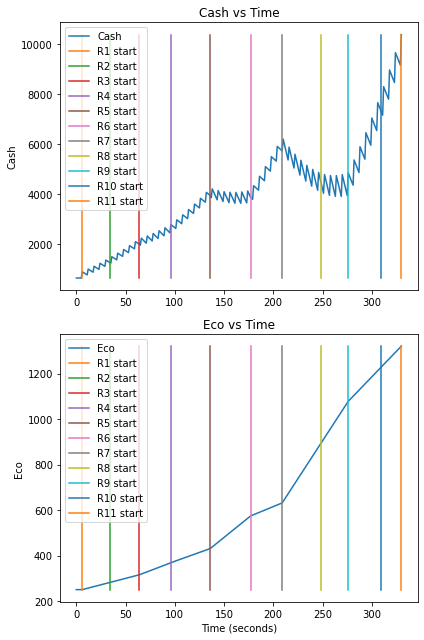

In [40]:
rounds = Rounds(1)

buy_queue = []
eco_queue = [(6.0, 'Grouped Reds'), (34.0, 'Grouped Reds'), (64.0, 'Grouped Blues'), (96.0, 'Spaced Pinks'), (136.0, 'Grouped Greens'), (177.0, 'Spaced Whites'), (209.0, 'Grouped Yellows'), (248.0, 'Grouped Yellows'), (276.0, 'Spaced Zebras'), (309.0, 'Spaced Zebras'), (330.0, 'Spaced Leads')]

initial_state = {
    'Cash': 650,
    'Eco': 250,
    'Eco Send': 'Zero',
    'Rounds': rounds,
    'Game Round': 0,
    'Buy Queue': buy_queue,
    'Eco Queue': eco_queue
}
game_state = GameState(initial_state)
game_state.fastForward(target_round=11)
game_state.viewCashEcoHistory()
writeLog(game_state.logs, filename = 'spoonoil')

## Sniper Farms in the mid-game

Our goal is to investigate optimal use of supply drops in a mid-game scenario. Most importantly, we seek to answer the following questions:
1. When should a player stop pink eco'ing when building supply drops?
2. When should a player stop building supply drops?

I'm going to assume the player has 2500 eco in a reasonably stalled game (stall factor of 0.5) and that the player has bought e-sniper midway through Round 21.

,Game State,Farm Income
0,0,0
1,1,0
2,2,0


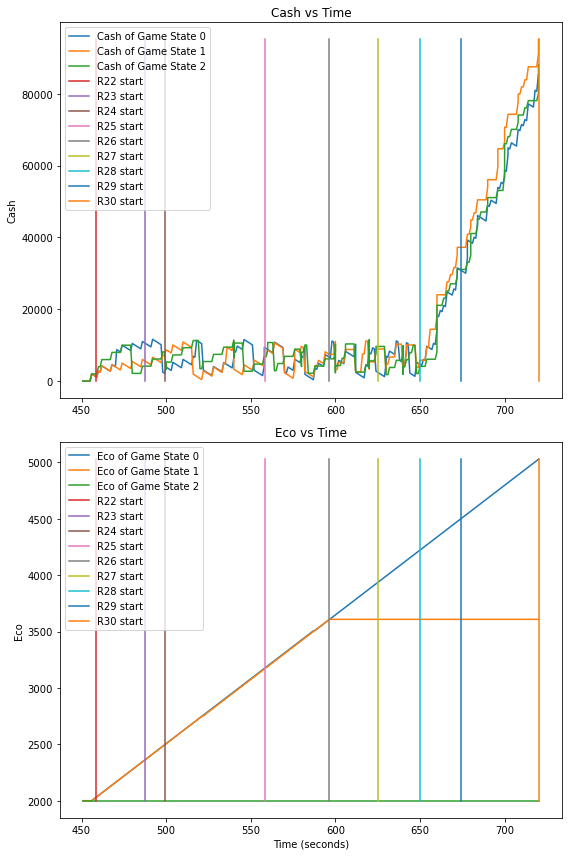

In [41]:
##############################
# DEFINING INITIAL GAME PARAMS
##############################

rounds = Rounds(0.2)

supply_drops = initSupplyDrops([rounds.getTimeFromRound(21.5)], elite_sniper = 0)
#print(supply_drops)

buy_queues = []
eco_queues = []

for i in range(3):
    if i == 0:
        eco_queues.append([])
        buy_queues.append([[repeatedlyBuySupplyDrops(min_buy_time = 0, max_buy_time = rounds.getTimeFromRound(28), buffer = 1800)]])
    elif i == 1:
        eco_queues.append([(rounds.getTimeFromRound(26),'Zero')])
        buy_queues.append([[repeatedlyBuySupplyDrops(min_buy_time = 0, max_buy_time = rounds.getTimeFromRound(28), buffer = 1800)]])
    elif i == 2:
        eco_queues.append([(rounds.getTimeFromRound(21.5),'Zero')])
        buy_queues.append([[repeatedlyBuySupplyDrops(min_buy_time = 0, max_buy_time = rounds.getTimeFromRound(28), buffer = 1800)]])
    

initial_state = {
    'Cash': 0,
    'Eco': 2000,
    'Eco Send': 'Grouped Pinks',
    'Rounds': rounds,
    'Game Round': 21.5,
    'Supply Drops': supply_drops
}

compareStrategies(initial_state, eco_queues, buy_queues, target_round = 30)

## The R22 IMF All-Out

In some cases, players may decide to abort their usual farming flowchart in favor of building an IMF Loan and all-outing on R22. We assume the player *just* before the start of round 20 has access to 1300 eco and a 420 BRF and simulate this flowchart as follows:

Round | Action to Take
---|---
21 | Purchase 240 farm
22 | Sell BRF
23 | Withdraw money from IMF
23 | Activate IMF Loan
23 | Sell IMF

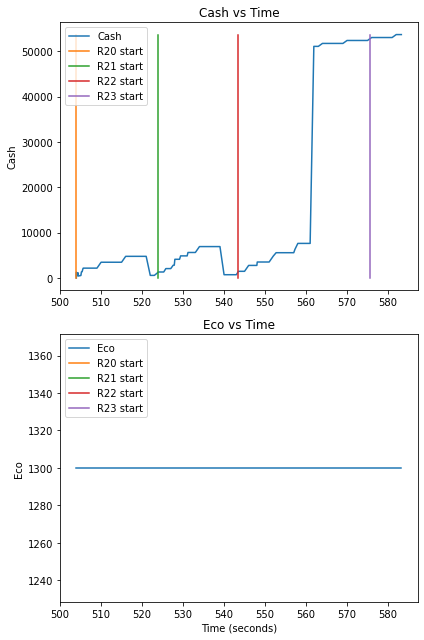

In [42]:
##############################
# DEFINING INITIAL GAME PARAMS
##############################

rounds = Rounds(0.5)

farms = {
    0: initFarm(0, upgrades = [4,2,0])
}

buy_queue = [
    #Buy a 240 Farm
    [buyFarm()],
    [upgradeFarm(1,0)],
    [upgradeFarm(1,0)],
    [upgradeFarm(1,1)],
    [upgradeFarm(1,1)],
    [upgradeFarm(1,1)],
    [upgradeFarm(1,1)],
    
    #Wait until the start of R22, then...
    #Sell the BRF, cash out the money in the Monkey Bank, Activate IMF Loan, and then sell the IMF Bank
    [sellFarm(0, min_buy_time = rounds.getTimeFromRound(22)), withdrawBank(1), activateIMF(1), sellFarm(1)]
]

initial_state_game = {
    'Cash': 0,
    'Eco': 1300,
    'Eco Send': 'Zero',
    'Rounds': rounds,
    'Game Round': 19.999,
    'Buy Queue': buy_queue,
    'Farms': farms
}
game_state = GameState(initial_state_game)

game_state.fastForward(target_round = 23.5)
game_state.viewCashEcoHistory()
writeLog(game_state.logs, filename = 'imf_flowchart')

## MWS Into Banana Central: Compound Purchases

We demonstrate a typical build into a R27 Banana Central starting from Round 24. We assume we are halfway through the round in a half-stalled game in possession of 2 x 204 farms + 1 x 420 farm. The flowchart for Banana Central proceeds as follows

Round | Action to Take
---|---
24 | (EOR) Sell 1 x 420 + 1 x 204 farm into 205 farm
~25 | Build 1 x 420 farm
~26 | Build 1 x 420 farm
~27 | Sell 205 farm into 520 farm

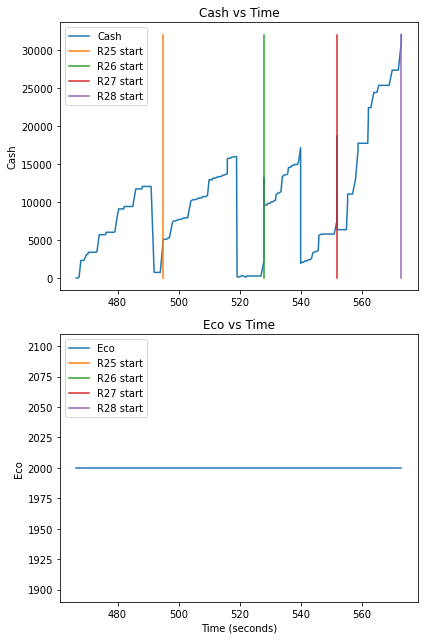

In [43]:
##############################
# DEFINING INITIAL GAME PARAMS
##############################

rounds = Rounds(0.0)

farms = {
    0: initFarm(0, upgrades = [4,2,0]), 
    1: initFarm(0, upgrades = [2,0,4]),
    2: initFarm(rounds.getTimeFromRound(19.999), upgrades = [2,0,4])
}

buy_queue = [
    
    #Sell into MWS
    [sellFarm(0), sellFarm(1), upgradeFarm(2,2)], 
    
    #Buy a 420 Farm
    [buyFarm()],
    [upgradeFarm(3,0)],
    [upgradeFarm(3,0)],
    [upgradeFarm(3,0)],
    [upgradeFarm(3,1)],
    [upgradeFarm(3,1)],
    [upgradeFarm(3,0)],
    
    #Buy another 420 Farm
    [buyFarm()],
    [upgradeFarm(4,0)],
    [upgradeFarm(4,0)],
    [upgradeFarm(4,0)],
    [upgradeFarm(4,1)],
    [upgradeFarm(4,1)],
    [upgradeFarm(4,0)],
    
    #Sell into BC
    [sellFarm(2),upgradeFarm(3,0)]
]

initial_state_game = {
    'Cash': 0,
    'Eco': 2000,
    'Eco Send': 'Zero',
    'Rounds': rounds,
    'Game Round': 24.5,
    'Farms': farms,
    'Buy Queue': buy_queue
}
game_state = GameState(initial_state_game)
game_state.fastForward(target_round = 28)
game_state.viewCashEcoHistory()
writeLog(game_state.logs, filename = 'bc_flowchart')


## Tack Wiz Farm R1 - R8: Quincy vs Ezili

In order for the eco/farm simulator to produce feasible results for matches, the player must account for defense-related expenses as the game progresses. To show how the code can accodomate for these sorts of scenarios, we consider a typical quincy tack wiz farm game in an anti-stalled environment, where the player attempts to purchase one 320 farm prior to the end of R8. The flow chart for defense looks generally like this:

Round | Action to Take
---|---
1 | Buy Quincy
1 | Buy 020 Tack
2 | Upgrade 020 Tack -> 120 Tack
3 | Upgrade 120 Tack -> 220 Tack
5 | Upgrade 220 -> 230 Tack
7 | Buy 011 Wiz
9 | Upgrade 011 Wiz -> 021 Wiz

,Game State,Farm Income
0,0,640
1,1,640


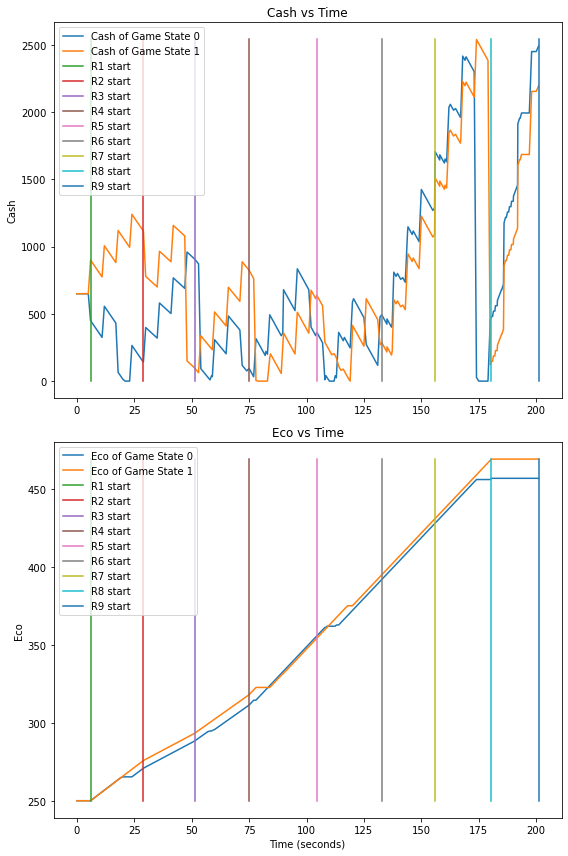

In [44]:
######################
# QUINCY TFW FLOWCHART
######################

rounds = Rounds(0.25)

buy_queue_quincy = [
    [buyDefense(450, min_buy_time = rounds.getTimeFromRound(1))], #Buy Quincy 
    [buyDefense(605)], #Buy 020 Tack
    [buyFarm()], #Buy the farm 
    [buyDefense(550)], #Upgrade to a 220 Tack 
    [upgradeFarm(0, 0, buffer = 250)], #Upgrade the farm to 100
    [buyDefense(605)], #Upgrade to 230 Tack 
    [upgradeFarm(0, 0, buffer = 250)], #Upgrade to 200 farm
    [upgradeFarm(0, 0, buffer = 0)] #Upgrade to 300 farm
]

eco_queue_quincy = [
    (rounds.getTimeFromRound(1), 'Grouped Reds'),
    (rounds.getTimeFromRound(2), 'Spaced Greens',),
    (rounds.getTimeFromRound(3), 'Spaced Yellows'),
    (rounds.getTimeFromRound(4), 'Spaced Pinks',),
    (rounds.getTimeFromRound(8), 'Zero',)
]

######################
# EZILI TFW FLOWCHART
######################

buy_queue_ezili = [
    [buyDefense(600, min_buy_time = rounds.getTimeFromRound(1.9))], #Buy Ezili 
    [buyDefense(1205)], #Buy 030 Tack
    [buyFarm()], #Buy the farm 
    [buyDefense(150)], #Upgrade to a 130 Tack 
    [upgradeFarm(0, 0, buffer = 250)], #Upgrade the farm to 100
    [buyDefense(400)], #Upgrade to 230 Tack 
    [upgradeFarm(0, 0, buffer = 250)], #Upgrade to 200 farm
    [upgradeFarm(0, 0, buffer = 0)] #Upgrade to 300 farm
]

eco_queue_ezili = [
    (rounds.getTimeFromRound(1), 'Grouped Reds'),
    (rounds.getTimeFromRound(2), 'Spaced Greens'),
    (rounds.getTimeFromRound(3), 'Spaced Yellows'),
    (rounds.getTimeFromRound(4), 'Spaced Pinks'),
    (rounds.getTimeFromRound(8), 'Zero')
]

eco_queues, buy_queues = [eco_queue_quincy, eco_queue_ezili], [buy_queue_quincy, buy_queue_ezili]

initial_state = {
    'Cash': 650,
    'Eco': 250,
    'Eco Send': 'Zero',
    'Rounds': rounds,
    'Game Round': 0
}

compareStrategies(initial_state, eco_queues, buy_queues, target_round = 9)

## The pre-round 20 BRF

We now consider a scenario typical of farm play where the user attempts to purchase BRF prior to the start of round 20.
In this scenario, we assume that the player on R18 has achieved 1 x 320 and 1 x 203 farms, 1200 eco, and intends to sell the 203 farm so as to afford the 420 farm. We assume that the player does *not* eco during this time period.

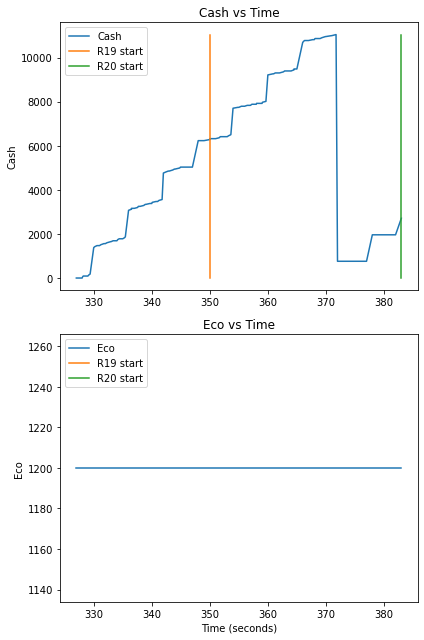

In [45]:
rounds = Rounds(0)

farms = {
    0: initFarm(0, upgrades = [3,2,0]), 
    1: initFarm(0, upgrades = [2,0,3])
}

buy_queue = [
    [sellFarm(1), upgradeFarm(0, 0, buffer = 0)]
]

initial_state_game = {
    'Cash': 0,
    'Eco': 1200,
    'Eco Send': 'Zero',
    'Rounds': rounds,
    'Game Round': 18,
    'Farms': farms,
    'Buy Queue': buy_queue
}
game_state = GameState(initial_state_game)
game_state.fastForward(target_round = 20)
game_state.viewCashEcoHistory()

## Optimizing the Pre-R20 BRF

In the above example, we see that the BRF is actually afforded with plenty of time to spare. However, in high-level play, players may see it desirable in this given mini-scenario to eco as much as possible while still being able to afford the 420 farm in time for R20.

In this extension of Case 2, we determine the longest amount of time that can be spent eco'ing grouped blacks while still being able to afford a pre-R20 BRF.

The optimal time to stop eco'ing is 479.09
That is, the player should stop eco'ing 13.59 seconds into round 19


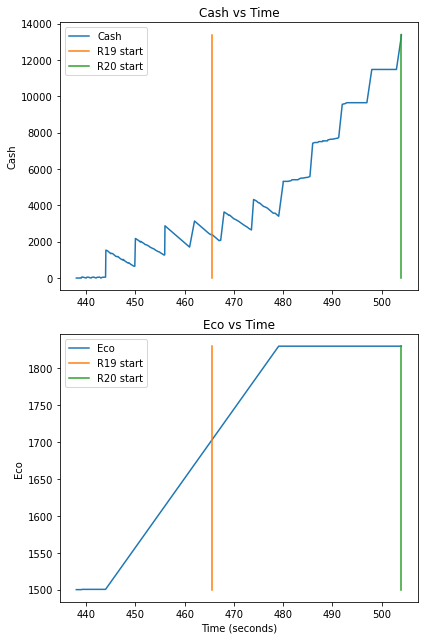

In [46]:
def foo(stop_time, game_state):
    game_state.eco_queue = [
        (stop_time,'Zero')
    ]
    game_state.fastForward(target_round = 19.999)
    
    #print("Foo returned " + str(game_state.cash - 11480))
    return game_state.cash - 11480

#Next, let's attempt to find the zero of foo using bisection method
farms = {
    0: initFarm(0, upgrades = [3,2,0]), 
    1: initFarm(0, upgrades = [2,0,3])
}

rounds = Rounds(0.5)

initial_state_game = {
    'Cash': 0,
    'Eco': 1500,
    'Eco Send': 'Grouped Blacks',
    'Rounds': rounds,
    'Game Round': 18,
    'Farms': farms,
    'Buy Queue': buy_queue
}

iterations = 20
a = rounds.getTimeFromRound(18)
b = rounds.getTimeFromRound(19.99)
for i in range(iterations):
    game_state_0 = GameState(initial_state_game)
    game_state_1 = GameState(initial_state_game)
    c = 0.5*(a+b)
    if foo(a, game_state_0)*foo(c, game_state_1) < 0:
        b = c
    else:
        a = c
        
    #print("New stop time: " + str(0.5*(a+b)))

c = 0.5*(a+b)

game_state = GameState(initial_state_game)
game_state.eco_queue = [
    (c,'Zero')
]
game_state.fastForward(target_round=20)
game_state.viewCashEcoHistory()

round_of_interest = rounds.getRoundFromTime(c)
time_into_round = c - rounds.round_starts[round_of_interest]
print("The optimal time to stop eco'ing is %s"%(np.round(c,2)))
print("That is, the player should stop eco'ing %s seconds into round %s"%(np.round(time_into_round,2),round_of_interest))

## Tigerz72's Tack Mortar Glue with Spaced Yellows

A run through of the tack mortar glue flowchart from round 1 to the start of round 8

Current Cash and Eco: (165.0,771.0)


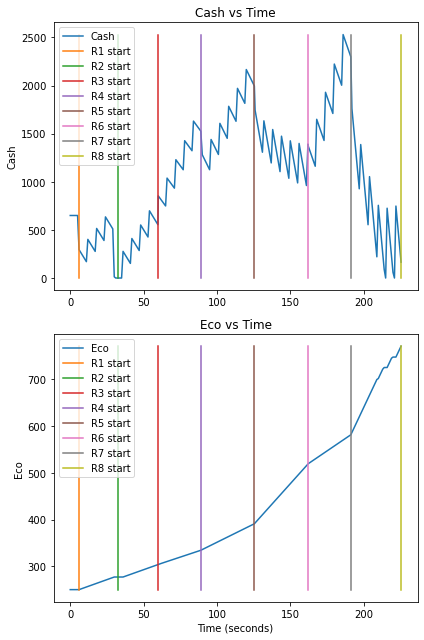

In [59]:
rounds = Rounds(0.75)

x = 0.1
eco_queue = [
    (rounds.getTimeFromRound(1-x), 'Grouped Reds'),
    (rounds.getTimeFromRound(3-x), 'Spaced Yellows'),
    (rounds.getTimeFromRound(4-x), 'Spaced Pinks'),
    (rounds.getTimeFromRound(5-x), 'Grouped Greens'),
    (rounds.getTimeFromRound(6-x), 'Spaced Blacks'),
    (rounds.getTimeFromRound(7-x), 'Grouped Yellows')
]

buy_queue = [
    [buyDefense(280+100+225, min_buy_time = rounds.getTimeFromRound(1))], #Buy 020 tack
    [buyDefense(750)], #Buy Striker Jones
    [buyDefense(550, min_buy_time = rounds.getTimeFromRound(4))], #Upgrade the tack to 220
    [buyDefense(600, min_buy_time = rounds.getTimeFromRound(5))], #Upgrade the tack to 230
    [buyDefense(1000, min_buy_time = rounds.getTimeFromRound(7))] #Buy 010 mortar
]

initial_state_game = {
    'Cash': 650,
    'Eco': 250,
    'Eco Send': 'Zero',
    'Rounds': rounds,
    'Game Round': 0,
    'Eco Queue': eco_queue,
    'Buy Queue': buy_queue
}

game_state = GameState(initial_state_game)
game_state.fastForward(target_round = 8)
game_state.viewCashEcoHistory()
writeLog(game_state.logs, filename = 'tack_mortar_glue')
print("Current Cash and Eco: (%s,%s)"%(np.round(game_state.cash,0),np.round(game_state.eco,0)))